In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
#from coherence_detection import *

In [3]:
# apply a threshold to a vector
# if U = sin(2*pi*x) and eps=0.25
# the following algorithm will reduce 
# all values of U towards zero by an amount of 0.25
def threshold(U,eps):
    # remove all values smaller than esp

    V = np.abs(U)-eps
    
    return np.sign(U) * np.maximum(V,np.zeros_like(V))

# find an approximation based on the coherent motion
# apply singular value decomposition of a matrix U
# threshold the singular values with eps
# reconstruct the matrix V
# the result V is the best approximation 
# with respect to thresholded POD modes

def best_pod_modes(U,eps):
    # SVD
    Phi,Sig,PsiT = np.linalg.svd(U,full_matrices=0)
    
    # soft threshold
    rSig = threshold(Sig,eps)

    # reconstruct
    V = np.linalg.multi_dot([Phi*rSig,PsiT])

    return V

def coherence_detection(U, iter):
    # U is n x m matrix
    n, m = U.shape

    # assign mu (penalty), lambda, delta
    mu = n * m/(4*np.sum(np.abs(U.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n, m))
    delta = 10**(-7) * np.linalg.norm(U)

    # initialize matrices
    # incoherent part
    Ui = np.zeros_like(U)
    
    # Lagrange multiplier auxiliary part for ADMM
    Y = np.zeros_like(U)
    
    # coherent part
    Uc = np.zeros_like(U)

    # start iteration
    count = 0
    while (np.linalg.norm(U-Uc-Ui) > delta) and (count < iter):

        # predict the coherent motion based on the best pod modes
        Uc = best_pod_modes(U-Ui+(1/mu)*Y,1/mu)

        # apply a threshold into the incoherent motion
        Ui = threshold(U-Uc+(1/mu)*Y,lambd/mu)

        # update the Lagrange multiplier
        Y = Y + mu*(U-Uc-Ui)
        count += 1
        
    return Uc,Ui




In [4]:
# read the data matrix N x n
# each column is an image or matrix, 
# which was reshaped to a vector

dat = np.loadtxt("code/spiral_flow_clean128.csv",delimiter=",")
#eta = 0.2*np.std(dat)
#eta

In [5]:
# add some salt and papper 
# below is a commonly used algorithm to add white noise
sz = dat.size
st = 0.2 # 10% noise

nz_dim = int(sz*st) # noise dimension

# Randomly select indices
# where sz is size of data matrix
# and nz_dim is length of noise data.
idx = np.random.choice(sz, nz_dim)

# Create a copy of the original matrix
# which is the noisy data.
Unoisy = dat.copy()

# Create a random noise random between min and max values of the data.
noise = np.random.choice([dat.min(), dat.max()], nz_dim)

# Replace the values of the templated noised data
# at random indices with the noise, 
# to obtain the final noised data.
# note idx is a subset of indices of our data matrix
# if the data matrix is flat

Unoisy.flat[idx] = noise


In [ ]:
# below is an algorithm to model salt and papper noise
np.random.seed(12345)

N = dat.shape[0]
n = dat.shape[1]

# create random mask of the elements of data
# mask is N x n matrix of true (1) or false (0)
mask = np.random.choice([1,0],(N,n))

# choose a value that will replace the original value
# at the mask index

eta = 0.1*np.std(dat)
# save the clean data
datc = dat
dati = np.random.normal(0, eta, dat.shape) 
# Add the noise matrix
#Unoisy = datc+dati
eta

0.09748822458565665

In [7]:

t0 = time.process_time()
Uc, Ui = coherence_detection(Unoisy, 50)
t1 = time.process_time()
print(t1-t0)

840.081849229


(150, 9)

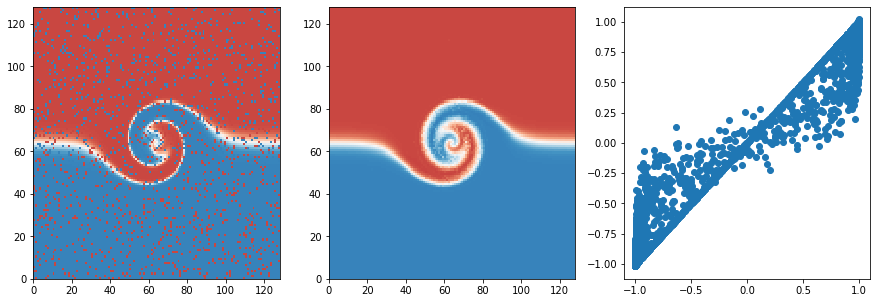

In [8]:
# convert a column of the data to a matrix
# Here, N = nx x ny.
# plot the 50 th column of the data as an image
# compare the noisy data the the reconstructed data
# compare the correlation between the data and reconstructed data

nx = 128
ny = 128
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.pcolormesh(Unoisy[:,50].reshape(nx,ny).T, cmap='RdBu_r',vmin=-1.5,vmax=1.5)
plt.subplot(1,3,2)
plt.pcolormesh(Uc[:,50].reshape(nx,ny).T, cmap='RdBu_r',vmin=-1.5,vmax=1.5)
plt.subplot(1,3,3)
plt.scatter(dat[:,50],Uc[:,50])

# compare the rank
np.linalg.matrix_rank(dat), np.linalg.matrix_rank(Uc)

# construct the low rank approximation of dat and compare with Uc
# what do you observe

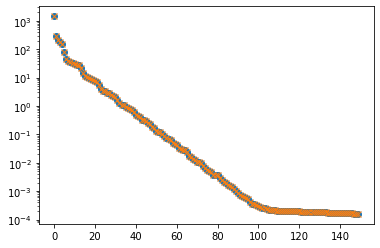

In [9]:
Phi, Sig, PsiT = np.linalg.svd(dat,full_matrices=0)
cPhi, cSig, cPsiT = np.linalg.svd(Uc,full_matrices=0)
plt.semilogy(Sig,'o')
plt.semilogy(Sig,'x')